In [7]:
import sys
sys.path.append("../src")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import umap
from sklearn.model_selection import train_test_split

from lib.pipeline import get_preprocessors, reduce_dimension, detect_outliers

from lib.i_o import read_csv

## Read data

In [8]:
df_x_train = read_csv("X_train.csv", "../data/").drop(columns="id")
df_y_train = read_csv("y_train.csv", "../data/").drop(columns="id")

Read data from ../data/X_train.csv
Read data from ../data/y_train.csv


In [9]:
df_x_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,10.227734,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,11.436970,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,10.810076,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,10.092109,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,12.006773,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


In [10]:
# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_x_train, df_y_train, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=1) 

In [11]:
print(f"#Features: {df_x_train.shape[1]}\n#observations: {df_x_train.shape[0]}")

#Features: 832
#observations: 1212


## Model training

In [35]:
# subsample 0.7, n_estimators: 75, max_features 0.9

In [ ]:
# Rewrite preprocessing and model as a sklearn pipeline
from sklearn.pipeline import Pipeline           
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from time import time, sleep

start_t = time()

selector_model = GradientBoostingRegressor(
    random_state=0,
    n_estimators=70,
    subsample=0.7,
    max_features=0.9,
    learning_rate=0.06
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler()),
('imputer', KNNImputer()),
('feature_selector', SelectFromModel(selector_model)),
('regression_model', GradientBoostingRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__weights="distance",
)

# Set grid / solution space
n_max_features_range = [0.9] #np.arange(0.7, 0.98, 0.025)
n_estim_range =  np.arange(30, 90, 5) # 50 - 90
n_subsample_range = [0.91] #np.arange(0.6, 1, 0.01) #0.6 - 0.9
learning_rate_range = np.arange(0.01, 0.2, 0.01)
feature_sel_threshold_range = [str(x)+"*mean" for x in np.arange(1, 2.1, 0.05)]

parameters = {
    'regression_model__subsample': n_subsample_range
    , 'feature_selector__threshold': feature_sel_threshold_range
    , 'regression_model__n_estimators':n_estim_range
    , 'regression_model__max_features': n_max_features_range
    , 'regression_model__learning_rate': learning_rate_range
}

# Train grided model
grided_model = GridSearchCV(pipe, parameters, scoring='r2', n_jobs=-1, cv=5, return_train_score=True)
grided_model.fit(X_train, np.array(y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

In [105]:
# Collect evaluation data into a data frame
df_cv_results = pd.DataFrame(grided_model.cv_results_)
df_model_params = df_cv_results.apply(lambda x: pd.Series(x["params"]), axis=1)
df_cv_results[df_model_params.columns] = df_model_params
df_cv_results.sort_values(by="rank_test_score", inplace=True)

In [106]:
grided_model.cv_results_["params"]

[{'feature_selector__threshold': '1.0*mean'},
 {'feature_selector__threshold': '1.05*mean'},
 {'feature_selector__threshold': '1.1*mean'},
 {'feature_selector__threshold': '1.1500000000000001*mean'},
 {'feature_selector__threshold': '1.2000000000000002*mean'},
 {'feature_selector__threshold': '1.2500000000000002*mean'},
 {'feature_selector__threshold': '1.3000000000000003*mean'},
 {'feature_selector__threshold': '1.3500000000000003*mean'},
 {'feature_selector__threshold': '1.4000000000000004*mean'},
 {'feature_selector__threshold': '1.4500000000000004*mean'},
 {'feature_selector__threshold': '1.5000000000000004*mean'},
 {'feature_selector__threshold': '1.5500000000000005*mean'},
 {'feature_selector__threshold': '1.6000000000000005*mean'},
 {'feature_selector__threshold': '1.6500000000000006*mean'},
 {'feature_selector__threshold': '1.7000000000000006*mean'},
 {'feature_selector__threshold': '1.7500000000000007*mean'},
 {'feature_selector__threshold': '1.8000000000000007*mean'},
 {'feat

In [107]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score'
    , 'regression_model__n_estimators'
    #, 'regression_model__max_features'
    #, 'regression_model__subsample'
    #, 'regression_model__learning_rate'
]].head(20)

KeyError: "['regression_model__n_estimators'] not in index"

In [79]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score',
    'regression_model__max_features', 
    'regression_model__n_estimators',
    'regression_model__subsample',
    'regression_model__learning_rate'
]].loc[18]

mean_test_score                     0.488885
mean_train_score                    0.852114
std_test_score                      0.037214
std_train_score                     0.003945
regression_model__max_features      0.900000
regression_model__n_estimators     35.000000
regression_model__subsample         0.910000
regression_model__learning_rate     0.190000
Name: 18, dtype: float64

<Axes: xlabel='regression_model__n_estimators', ylabel='mean_test_score'>

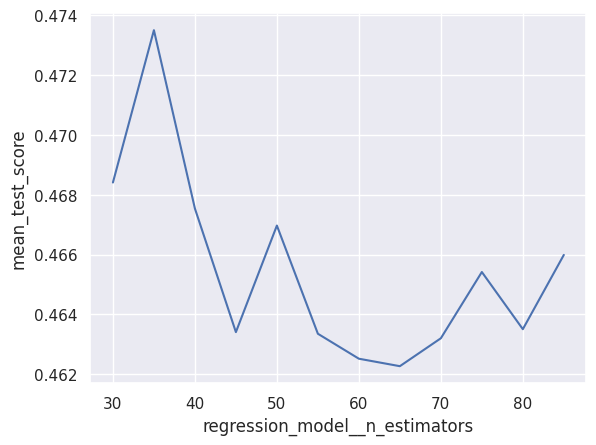

In [89]:
sns.lineplot(data=df_cv_results, x='regression_model__n_estimators', y='mean_test_score')

<Axes: xlabel='regression_model__n_estimators', ylabel='mean_train_score'>

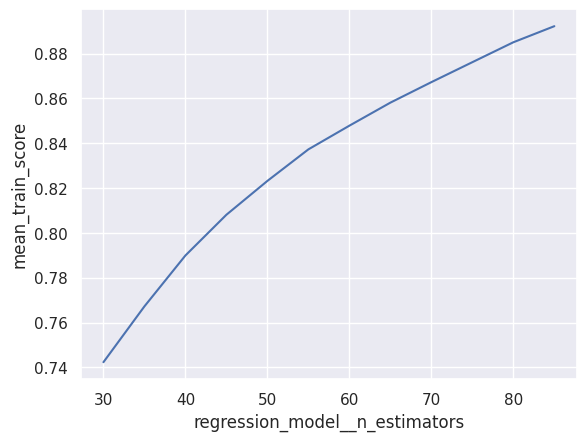

In [91]:
sns.lineplot(data=df_cv_results, x='regression_model__n_estimators', y='mean_train_score')

In [ ]:
train_pred = grided_model.predict(X_train)
val_pred = grided_model.predict(X_val)

In [ ]:
validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train_inliers, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}")

## Model testing

In [97]:
from sklearn.pipeline import Pipeline           
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from time import time, sleep

start_t = time()

selector_model = GradientBoostingRegressor(
    random_state=0,
    n_estimators=70,
    subsample=0.7,
    max_features=0.9,
    learning_rate=0.06
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler()),
('imputer', KNNImputer()),
('feature_selector', SelectFromModel(selector_model)),
('regression_model', GradientBoostingRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__weights="distance",
    feature_selector__threshold="2*mean",
)

# Set grid / solution space
n_max_features_range = [0.9] #np.arange(0.7, 0.98, 0.025)
n_estim_range =  [35]
n_subsample_range = [0.91]
learning_rate_range = [0.19]

# Train grided model
grided_model = GridSearchCV(pipe, parameters, scoring='r2', n_jobs=-1, cv=5, return_train_score=True)
grided_model.fit(X_train, np.array(y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

TypeError: GridSearchCV.__init__() missing 1 required positional argument: 'param_grid'

In [101]:
np.arange(1, 2.1, 0.05)

array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05])